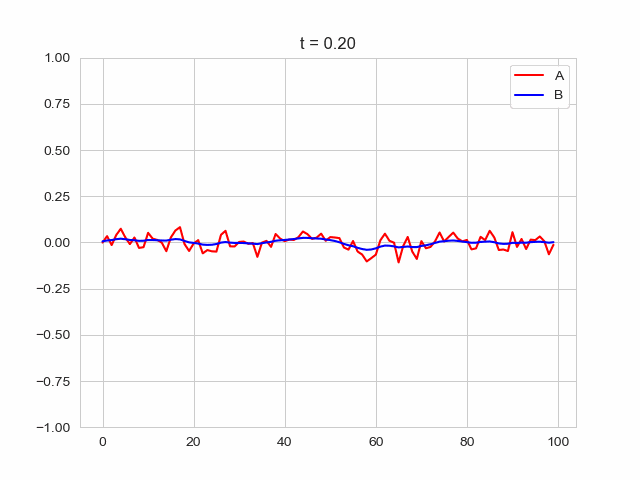

In [1]:
# Model 1: Recreation of Basic Turing Stripes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

%matplotlib inline
%reload_ext autoreload
%autoreload 2

sns.set_style("whitegrid")

class BaseStateSystem:
    """
    Base object for "State System".

    We are going to repeatedly visualise systems which are Markovian:
    the have a "state", the state evolves in discrete steps, and the next
    state only depends on the previous state.

    To make things simple, I'm going to use this class as an interface.
    """
    def __init__(self):
        raise NotImplementedError()

    def initialise(self):
        raise NotImplementedError()

    def initialise_figure(self):
        fig, ax = plt.subplots()
        return fig, ax

    def update(self):
        raise NotImplementedError()

    def draw(self, ax):
        raise NotImplementedError()

    def plot_time_evolution(self, filename, n_steps=30):
        """
        Creates a gif from the time evolution of a basic state syste.
        """
        self.initialise()
        fig, ax = self.initialise_figure()

        def step(t):
            self.update()
            self.draw(ax)

        anim = animation.FuncAnimation(fig, step, frames=np.arange(n_steps), interval=20)
        anim.save(filename=filename, dpi=60, fps=10, writer='imagemagick')
        plt.close()
        
    def plot_evolution_outcome(self, filename, n_steps):
        """
        Evolves and save the outcome of evolving the system for n_steps
        """
        self.initialise()
        fig, ax = self.initialise_figure()
        
        for _ in range(n_steps):
            self.update()

        self.draw(ax)
        fig.savefig(filename)
        plt.close()
        
def laplacian1D(a, dx):
    return (
        - 2 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
    ) / (dx ** 2)

def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

def random_initialiser(shape):
    return(
        np.random.normal(loc=0, scale=0.05, size=shape),
        np.random.normal(loc=0, scale=0.05, size=shape)
    )

class OneDimensionalRDEquations(BaseStateSystem):
    def __init__(
        self, Da, Db, Ra, Rb,
        initialiser=random_initialiser,
        width=1000, dx=1, 
        dt=0.1, steps=1
    ):
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb
        self.initialiser = initialiser
        self.width = width
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.width)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        a, b = self.a, self.b
        Da, Db = self.Da, self.Db
        Ra, Rb = self.Ra, self.Rb
        dt, dx = self.dt, self.dx
        
        La = laplacian1D(a, dx)
        Lb = laplacian1D(b, dx)
        
        delta_a = dt * (Da * La + Ra(a, b))
        delta_b = dt * (Db * Lb + Rb(a, b))
        
        self.a += delta_a
        self.b += delta_b
        
    def draw(self, ax):
        ax.clear()
        ax.plot(self.a, color="r", label="A")
        ax.plot(self.b, color="b", label="B")
        ax.legend()
        ax.set_ylim(-1, 1)
        ax.set_title(f"t = {self.t:.2f}")
        
    def plot_time_evolution(self, filename, n_steps=150, fps=10):
        # Initialize the system
        self.initialise()
        
        fig, ax = plt.subplots()

        def update_frame(i):
            self.update()
            self.draw(ax)

        anim = FuncAnimation(
            fig,
            update_frame,
            frames=n_steps,
            interval=50, 
            repeat=False
        )
        
        # Explicitly use PillowWriter
        writer = PillowWriter(fps=fps)
        anim.save(filename, writer=writer)
        plt.close(fig)

Da, Db, alpha, beta = 1, 100, -0.005, 10
def Ra(a, b): return a - a**3 - b + alpha
def Rb(a, b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

system = OneDimensionalRDEquations(Da, Db, Ra, Rb, width=width, dx=dx, dt=dt, steps=100)
system.plot_time_evolution("1dRD.gif", n_steps=150)
Image("1dRD.gif")

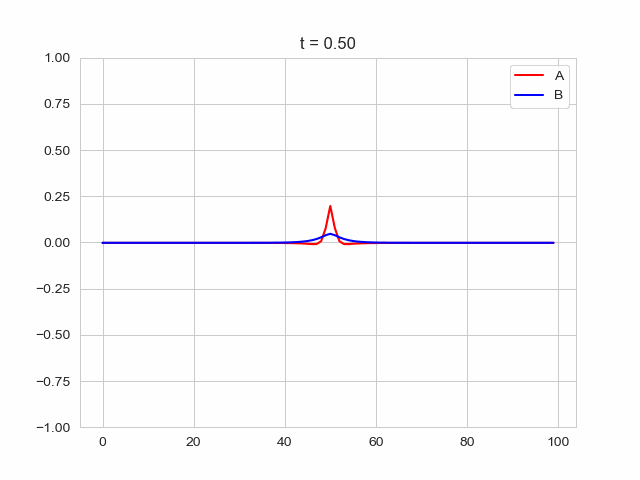

In [2]:
# Model 2: Introduction of Apical Cell Behavior
Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a,b): 
    return a - a**3 - b + alpha

def Rb(a,b): 
    return (a - b) * beta

def initalise_bump(shape):
    a = np.zeros(shape)
    # 1D case: place a 'bump' in the middle
    if len(a.shape) == 1:
        a[a.shape[0] // 2] = 0.3
    # 2D case (if you ever switch to 2D):
    elif len(a.shape) == 2:
        a[a.shape[0] // 2, a.shape[1] // 2] = 0.3

    return (a, np.zeros(shape))

width = 100
dx = 1
dt = 0.001

# Instantiate the system
system = OneDimensionalRDEquations(
    Da, Db, Ra, Rb,
    initialiser=initalise_bump,
    width=width,
    dx=dx,
    dt=dt,
    steps=250
)

# Now call plot_time_evolution, which uses PillowWriter internally.
system.plot_time_evolution("1dRD_initial_bump.gif", n_steps=150)
Image("1dRD_initial_bump.gif")